In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    SpectralModel,
    SkyModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
os.environ['GAMMAPY_DATA'] = '/home/rishank/gammapy-datasets/'
!echo $GAMMAPY_DATA
!ls $GAMMAPY_DATA

/home/rishank/gammapy-datasets/
catalogs	     ebl	    figures	  images
cta-1dc		     fermi_3fhl     gamma-cat	  joint-crab
dark_matter_spectra  fermi-3fhl-gc  hess-dl3-dr1  tests


In [4]:
crab_spectrum = PowerLawSpectralModel(
    amplitude=1e-11 / u.cm ** 2 / u.s / u.TeV,
    reference=1 * u.TeV,
    index=2.3,
)

crab_model = SkyModel(spectral_model=crab_spectrum)
print(crab_model)

SkyModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.300e+00   nan                nan nan  False
amplitude 1.000e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
datasets = []
for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce()

In [6]:
# Set model and fit range
dataset_hess.models = crab_model
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset_hess.mask_fit = dataset_hess.counts.energy_mask(e_min, e_max)

In [7]:
fit = Fit([dataset_hess])

In [8]:
minuit_opts = {"tol": 0.001, "strategy": 1}
result_minuit = fit.run(optimize_opts=minuit_opts)
print(result_minuit)
result_minuit.parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 72
	total stat : 33.54



name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
index,2.603e+00,9.838e-02,,nan,nan,False
amplitude,3.942e-11,3.332e-12,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


In [9]:
def evaluate_err(self, minu, energy, epsilon=1e-4):

        p_cov = minu.parameters.covariance
        eps = np.sqrt(np.diag(minu.parameters.covariance)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [10]:
def plot_error(
        self,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,result_minuit,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

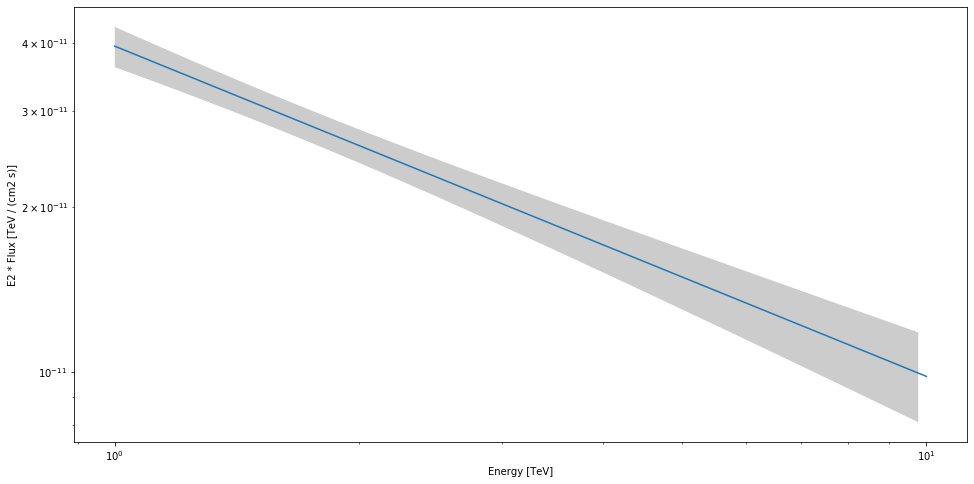

In [11]:
energy_range = [1, 10] * u.TeV
plt.figure(figsize=[16,8])
crab_spectrum.plot(energy_range=energy_range, energy_power=2)
ax = plot_error(self=crab_spectrum,energy_range=energy_range, energy_power=2)

In [12]:
profile = fit.stat_profile(parameter="index")

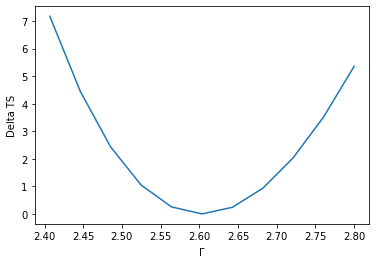

In [13]:
total_stat = result_minuit.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel(r"$\Gamma$")
plt.ylabel("Delta TS");

In [14]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["index", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour["x"].tolist(),
                par_2: contour["y"].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

In [15]:
sigma = [1, 2]
cts_sigma = make_contours(fit, result_minuit, 10, sigma)

In [16]:
pars = {
    "phi": r"$phi_0 / (10^{-11} {TeV}^{-1} {cm}^{-2} {s}^{-1})$",
    #"phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "index": r"$index$",
}

panels = [
    {
        "x": "index",
        "y": "phi",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    }
]

In [17]:
def plot_contour_line(ax, x, y, **kwargs):
    """Plot smooth curve from contour points"""
    from scipy.interpolate import CubicSpline

    # close countour
    xf = np.append(x, x[0])
    yf = np.append(y, y[0])

    # curve parametrization must be strictly increasing
    # so we use the cumulative distance of each point from the first one
    dist = np.sqrt(np.diff(xf) ** 2.0 + np.diff(yf) ** 2.0)
    dist = [0] + list(dist)
    t = np.cumsum(dist)
    ts = np.linspace(0, t[-1], 50)

    # 1D cubic spline interpolation
    cs = CubicSpline(t, np.c_[xf, yf], bc_type="periodic")
    out = cs(ts)

    # plot
    ax.plot(out[:, 0], out[:, 1], "-", **kwargs)
    ax.plot(xf, yf, "+", color=kwargs["color"])

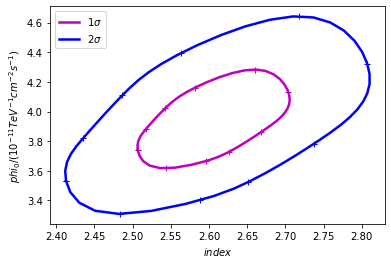

In [18]:
axes = plt.axes()
colors = ["m","b"]
xlabel = pars[panels[0]["x"]]
ylabel = pars[panels[0]["y"]]
for ks in range(len(cts_sigma)):
    plot_contour_line(
        axes,
        panels[0]["cx"](cts_sigma[ks]),
        panels[0]["cy"](cts_sigma[ks]),
        lw=2.5,
        color=colors[ks],
        label=f"{sigma[ks]}" + r"$\sigma$",
    )
axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
plt.legend()
